In [1]:
import numpy as np
import dataIO
from VBGP import VBGP
from sklearn import cross_validation, linear_model, preprocessing, svm
reload(dataIO)

postures = {"left_hand":["4", "8", "11"], "right_hand":["1", "7", "10"], 
            "index_finger":["3", "5", "12"], "two_hand":["2", "6", "9"]}

locations = []
bod = []
targets_x = []
targets_y = []
y = []
touch_centers = []

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr

userId = 8
keys = postures.keys()
locations = []
bod = []
targets_x = []
targets_y = []
y = []
touch_centers = []

posture = 0
for key in keys:
    filenos = postures[key]
    if key == "two_hand":
        a, b, c, d, e, f = dataIO.process_twohand(userId, posture)
        posture += 2
    else:
        a, b, c, d, e, f = dataIO.process_posture(userId, filenos, posture)
        posture += 1
    
    locations += a
    bod += b
    targets_x += c 
    targets_y += d 
    y += e
    touch_centers += f

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

print("MSE on x before regression: %.2f"  % np.mean(targets_x ** 2))
print("MSE on y before regression: %.2f"  % np.mean(targets_y ** 2))
within_before = dataIO.circle_button_error(locations, touch_centers)

thetas = np.array([[1 for x in range(24)], [0.1 for x in range(24)], [0.01 for x in range(24)],
         [0.001 for x in range(24)],[10 for x in range(24)]])

foldno = 1
se_x = []
se_y = []
within_after = []
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)

for train_index, test_index in kf: 
    print
    print ("##### Fold %d #####"%foldno)
    print
    points_train, points_test = locations[train_index], locations[test_index]
    bod_train, bod_test = bod[train_index], bod[test_index]
    t_x_train, t_x_test = targets_x[train_index], targets_x[test_index]
    t_y_train, t_y_test = targets_y[train_index], targets_y[test_index]
    y_train, y_test = y[train_index], y[test_index]
    centers_train, centers_test = touch_centers[train_index], touch_centers[test_index]
    
    scaler = preprocessing.StandardScaler().fit(bod_train)  
    bod_scaled = scaler.transform(bod_train)
    test = scaler.transform(bod_test)
    
    gp = VBGP.VBGP()
    gp.fit(bod_scaled, y_train, theta=thetas[0], nos_its = 50, thresh = 0.1)
    gp.optimize(thetas, nos_its = 50, thresh = 0.1)
    
    print "Best gamma: %f" %gp.Theta[0][0]
    
    probabilities = gp.predict(test)    
    pred = np.argmax(probabilities, axis=1)
    
    regr_x = []
    regr_y = []
    
    for i in range(0,5):
        index = np.where(y_train==i)[0]
        regr_x.append(learn_offset(points_train[index], t_x_train[index]))
        regr_y.append(learn_offset(points_train[index], t_y_train[index]))
        
    new_points = np.zeros((len(points_test), 2))
    for i in range(len(points_test)):        
        point = points_test[i]
        
        pred_x = regr_x[pred[i]].predict(point)
        pred_y = regr_y[pred[i]].predict(point)
        
        new_points[i][0] = point[0]+pred_x
        new_points[i][1] = point[1]+pred_y
     
    within_after.append(dataIO.circle_button_error(new_points, centers_test))
    new_points = np.array(new_points).T
    centers_test = centers_test.T
    
    se_x.append((new_points[0]-centers_test[0])**2)
    se_y.append((new_points[1]-centers_test[1])**2)   
    foldno += 1

se_x = np.array([item for sublist in se_x for item in sublist])
se_y = np.array([item for sublist in se_y for item in sublist])

print 
print("Mean MSE on x: %.2f" % np.mean(se_x))
print("Mean MSE on y: %.2f" % np.mean(se_y))      
within_after = np.mean(np.array(within_after), 0)

MSE on x before regression: 305.11
MSE on y before regression: 128.41

##### Fold 1 #####

Best gamma: 0.100000


/users/level5/1005056p/miniconda/lib/python2.7/site-packages/GPy/util/linalg.py:48: UserWarning: warning: caught this exception:/users/level5/1005056p/miniconda/lib/python2.7/site-packages/numpy/core/_dotblas.so: undefined symbol: dsyrk_
  warnings.warn("warning: caught this exception:" + str(e))


NameError: name 'fold' is not defined

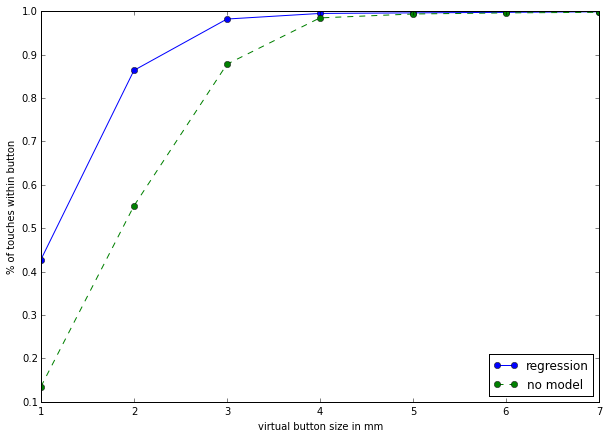

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,8), within_after, marker="o", label = "model")
plt.errorbar(range(1,8), within_before, linestyle="--", marker="o", label="no model")

plt.legend(loc='lower right')
plt.xlabel('virtual button size in mm')
plt.ylabel('% of touches within button')
plt.show()

#plt.savefig("predictpostures.png")